## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, np.int64(3009))

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    matrix = np.zeros((df.user_id.nunique(), df.item_id.nunique()))
    for _, row in df.iterrows():
        matrix[row.user_id, row.item_id] = row.rating
    return matrix #shape ~ [n_users, n_items]

In [10]:
interactions = df_to_matrix(df_train)

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame, interactions_col='rating') -> coo_array:
    coo = coo_array((df[interactions_col], (df.user_id, df.item_id)), 
                       shape=(df.user_id.nunique(), df.item_id.nunique()))
    return coo # coo_array

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
from scipy.sparse.linalg import svds


def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    # np.ndarray matrix
    if isinstance(interactions, np.ndarray):
        U, s, V = np.linalg.svd(interactions)
        S = np.zeros((U.shape[0], V.shape[1]))
        S[:len(s), :len(s)] = np.diag(s)

        if n_singular_values == -1:
            return U, S, V
        return U[:, :n_singular_values], S[:n_singular_values, :n_singular_values], V[:n_singular_values, :]

    # coo_array matrix
    if isinstance(interactions, coo_array):
        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1

        U, s, V = svds(interactions, k=n_singular_values)
        S = np.zeros((U.shape[0], V.shape[1]))
        S[:len(s), :len(s)] = np.diag(s)
        return U, S[:n_singular_values, :n_singular_values], V

    raise ValueError("Input matrix must be a numpy.ndarray or a scipy.sparse.coo_matrix")
 

In [15]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал
    interactions = interactions.toarray() if isinstance(interactions, coo_array) else interactions
    n_users = interactions.shape[0]

    U, S, V = make_svd(interactions=interactions, n_singular_values=n_singular_values)
    predicted = U @ S @ V
    recommendations = []

    for i in range(n_users):
        df_user_interactions = pd.DataFrame(data=(zip(interactions[i, :], predicted[i, :])), columns=['init', 'preds'])
        df_user_interactions['preds'] = df_user_interactions['preds'].astype(np.float64)
        df_user_interactions = df_user_interactions[df_user_interactions['init'] == 0].sort_values(by='preds', ascending=False).head(top_k)
        recommendations.append(df_user_interactions.index.to_numpy())
    
    return np.array(recommendations) # shape ~ [n_users, top_k]

In [18]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [19]:
def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_

def evaluate_recommender(df, model_preds='predicted_interactions', gt_col="test_interactions"):
    ndcg_values = []

    for _, row in df.iterrows():
        gt_items = row[gt_col]
        ndcg_values.append(ndcg_metric(gt_items, row[model_preds]))

    return np.mean(ndcg_values)



In [20]:
import time
from matplotlib import pyplot as plt

def plot_graphs(train_interactions: Union[np.ndarray, coo_array], df_test_interactions, top_k: int = 100):
    
    ndcg_metric_values = []
    n_singular_values = []
    processing_time_values = []
    

    for n_singular_value in [1, 10, 50, 200, 1000]:
        time_start = time.time()
        predicted_recs = make_svd_recommendations(train_interactions, n_singular_value, top_k)
        time_stop = time.time() - time_start
        df_svd_recs = pd.DataFrame({
            'user_id': range(len(predicted_recs)),
            'predicted_interactions': predicted_recs.tolist()
        })
        df_evaluate_svd_recs = pd.merge(df_svd_recs, df_test_interactions, on='user_id')
        ndcg_metric = evaluate_recommender(df_evaluate_svd_recs)
        print(f'n_singular_value = {n_singular_value}, ndcg = {ndcg_metric} -- done')
        ndcg_metric_values.append(ndcg_metric)
        n_singular_values.append(n_singular_value)
        processing_time_values.append(time_stop)

    # plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(n_singular_values, ndcg_metric_values, color='skyblue', linestyle='-', linewidth=2)
    plt.title('NDCG@k', fontsize=14)
    plt.xlabel('Singular Value', fontsize=12)
    plt.ylabel('NDCG@k Score', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.subplot(1, 2, 2)
    plt.plot(n_singular_values, processing_time_values, color='salmon', linestyle='-', linewidth=2)
    plt.title('Time', fontsize=14)
    plt.xlabel('Singular Value', fontsize=12)
    plt.ylabel('Time', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()


n_singular_value = 1, ndcg = 0.5396067152048136 -- done
n_singular_value = 10, ndcg = 0.5993511113914561 -- done
n_singular_value = 50, ndcg = 0.5800917068499524 -- done
n_singular_value = 200, ndcg = 0.5142513288927512 -- done
n_singular_value = 1000, ndcg = 0.3006861398194782 -- done


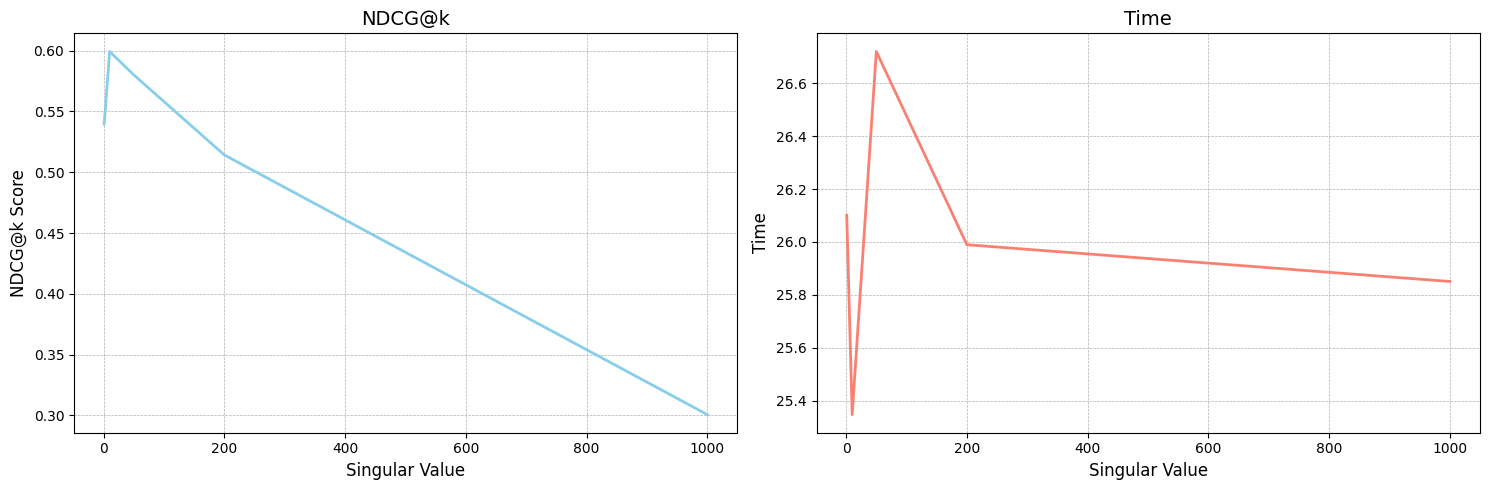

In [21]:
df_test_interactions = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
plot_graphs(coo_interactions, df_test_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [22]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    if isinstance(interactions, np.ndarray):
        interactions = csr_matrix(interactions)
    if isinstance(interactions, coo_array):
        interactions = csr_matrix(interactions)

    model = AlternatingLeastSquares(
        factors=n_factors, 
        regularization=regularization, 
        alpha=alpha
    )
    model.fit(interactions)
    
    n_users = interactions.shape[0]
    recs = model.recommend(list(range(n_users)), interactions, N=top_k, filter_already_liked_items=True)[0]
    return recs #shape ~ [n_users, top_k]

/Users/denis.bobylev/Documents/hse/RecSys/HW2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


In [24]:
df_als_recs = pd.DataFrame({
    'user_id': range(len(recs)),
    'predicted_interactions': recs.tolist()
})
df_evaluate_als_recs = pd.merge(df_als_recs, df_test_interactions, on='user_id')
ndcg_metric_als = evaluate_recommender(df_evaluate_als_recs)
print('ndcg_metric_als = ', ndcg_metric_als)

ndcg_metric_als =  0.5578474110202084


In [25]:
def evaluate_als(interactions, n_factors, alpha, regularization):
    recs = make_als_recommendations(interactions=interactions, n_factors=n_factors, alpha=alpha, regularization=regularization, top_k=100)
    df_als_recs = pd.DataFrame({
        'user_id': range(len(recs)),
        'predicted_interactions': recs.tolist()
    })
    df_evaluate_als_recs = pd.merge(df_als_recs, df_test_interactions, on='user_id')
    ndcg_metric_als = evaluate_recommender(df_evaluate_als_recs)

    return {'params': f'n_factors={n_factors}|alpha={alpha}|regularization={regularization}', 'ndcg_metric_als': ndcg_metric_als}
    

n_factors_range = [5, 10, 15]
alpha_range = [0.5, 1, 5]
regularization_range = [0, 0.01, 0.1, 1]

evaluation_metrics = []

for f in n_factors_range:
    for a in alpha_range:
        for r in regularization_range:
            evaluation_metrics.append(evaluate_als(interactions, f, a, r))


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


In [26]:
best_model_params = sorted(evaluation_metrics, key=lambda x: x["ndcg_metric_als"], reverse=True)[0]
best_model_params

{'params': 'n_factors=10|alpha=0.5|regularization=0.01',
 'ndcg_metric_als': np.float64(0.6009317885491754)}

Получилось качество лучше чем при SVD

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [27]:
als_model = AlternatingLeastSquares(
        factors=100, 
        regularization=0.01, 
        alpha=1.0
    )
interactions_csr = csr_matrix(interactions)

als_model.fit(interactions_csr)
n_users = interactions.shape[0]
als_recs = als_model.recommend(list(range(n_users)), interactions_csr, N=3, filter_already_liked_items=True)[0]
df_als_recs = pd.DataFrame({
    'user_id': range(len(als_recs)),
    'predicted_interactions': als_recs.tolist()
})
df_als_recs

100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


,user_id,predicted_interactions
0,0,"[670, 2132, 684]"
1,1,"[929, 944, 685]"
2,2,"[404, 968, 961]"
3,3,"[215, 432, 2308]"
4,4,"[2630, 878, 820]"
...,...,...
5360,5360,"[298, 1215, 1190]"
5361,5361,"[1709, 924, 875]"
5362,5362,"[580, 971, 2588]"
5363,5363,"[672, 2326, 774]"


In [28]:
df_movies = pd.read_csv('ml-1m/movies.dat', delimiter='::', encoding='ISO-8859-1', header=None)
df_movies.columns = ['ID', 'Title', 'Genres']
df_movies

/var/folders/_w/kwc87vq95knc__ftlw44x3kw0000gn/T/ipykernel_17912/1631822151.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_movies = pd.read_csv('ml-1m/movies.dat', delimiter='::', encoding='ISO-8859-1', header=None)


,ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [29]:
def get_movie_by_id(id, df_movies=df_movies, item_le=item_le):
    idx = item_le.inverse_transform([id])[0]
    return df_movies[df_movies['ID'] == idx]['Title'].values[0]

In [30]:
users = [0, 1, 2]

for user in users:
    recommended_items, scores = als_model.recommend(user, interactions_csr[user], N=3)
    print(f"User {user}:")
    for item, score in zip(recommended_items, scores):
        print(f"Recommended item: {get_movie_by_id(item)}, Score: {score:.2f}")
        total_score, top_contributions, _ = als_model.explain(user, interactions_csr, item)
        contributions = [(x[1], get_movie_by_id(x[0])) for x in top_contributions]
        print('total_score ', total_score)
        print('top_contributions ', contributions)
    print()

User 0:
Recommended item: North by Northwest (1959), Score: 0.81
total_score  0.7996975548889873
top_contributions  [(np.float64(0.14811963572375178), 'Rear Window (1954)'), (np.float64(0.11513571244170823), 'Casablanca (1942)'), (np.float64(0.1002264790363881), 'Citizen Kane (1941)'), (np.float64(0.09047319486159525), 'Airplane! (1980)'), (np.float64(0.08511000650094194), 'Psycho (1960)'), (np.float64(0.0657177697375364), 'Taxi Driver (1976)'), (np.float64(0.061061004104545444), 'Some Like It Hot (1959)'), (np.float64(0.05907673105789767), 'To Kill a Mockingbird (1962)'), (np.float64(0.052271539811576326), 'Wizard of Oz, The (1939)'), (np.float64(0.049917172700743105), 'Fargo (1996)')]
Recommended item: Christmas Story, A (1983), Score: 0.81
total_score  0.7936560700042969
top_contributions  [(np.float64(0.09705554886078058), 'Airplane! (1980)'), (np.float64(0.08533869359181831), 'To Kill a Mockingbird (1962)'), (np.float64(0.07898111925651598), 'Dog Day Afternoon (1975)'), (np.float6

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)

In [31]:
df_train['rating_1'] = np.where(df_train.rating > 0, 1, 0)
coo_array_1 = df_to_coo(df_train, 'rating_1')

In [32]:
svd_recs = make_svd_recommendations(coo_array_1, n_singular_values=100)
df_svd_recs = pd.DataFrame({
    'user_id': range(len(svd_recs)),
    'predicted_interactions': svd_recs.tolist()
})
df_evaluate_svd_recs = pd.merge(df_svd_recs, df_test_interactions, on='user_id')
ndcg_metric_svd = evaluate_recommender(df_evaluate_svd_recs)
print('NDCG SVD = ', ndcg_metric_svd)

NDCG SVD =  0.5508152767051381


In [33]:
als_recs = make_als_recommendations(interactions=coo_array_1)

df_als_recs = pd.DataFrame({
    'user_id': range(len(als_recs)),
    'predicted_interactions': als_recs.tolist()
})
df_evaluate_als_recs = pd.merge(df_als_recs, df_test_interactions, on='user_id')
ndcg_metric_als = evaluate_recommender(df_evaluate_als_recs)
print('NDCG ALS = ', ndcg_metric_als)

100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


NDCG ALS =  0.5568542180546557


2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0

In [34]:
df_train['rating_2'] = np.where(df_train.rating >= 4, 1, 0)
coo_array_2 = df_to_coo(df_train, 'rating_2')

In [35]:
svd_recs = make_svd_recommendations(coo_array_2, n_singular_values=100)
df_svd_recs = pd.DataFrame({
    'user_id': range(len(svd_recs)),
    'predicted_interactions': svd_recs.tolist()
})
df_evaluate_svd_recs = pd.merge(df_svd_recs, df_test_interactions, on='user_id')
ndcg_metric_svd = evaluate_recommender(df_evaluate_svd_recs)
print('NDCG SVD = ', ndcg_metric_svd)

NDCG SVD =  0.5211253509556841


In [36]:
als_recs = make_als_recommendations(interactions=coo_array_2)

df_als_recs = pd.DataFrame({
    'user_id': range(len(als_recs)),
    'predicted_interactions': als_recs.tolist()
})
df_evaluate_als_recs = pd.merge(df_als_recs, df_test_interactions, on='user_id')
ndcg_metric_als = evaluate_recommender(df_evaluate_als_recs)
print('NDCG ALS = ', ndcg_metric_als)

100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


NDCG ALS =  0.5594801572229002


3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1

In [37]:
df_train['rating_3'] = np.where(df_train.rating >= 4, 1, -1)
coo_array_3 = df_to_coo(df_train, 'rating_3')

In [38]:
svd_recs = make_svd_recommendations(coo_array_3, n_singular_values=100)
df_svd_recs = pd.DataFrame({
    'user_id': range(len(svd_recs)),
    'predicted_interactions': svd_recs.tolist()
})
df_evaluate_svd_recs = pd.merge(df_svd_recs, df_test_interactions, on='user_id')
ndcg_metric_svd = evaluate_recommender(df_evaluate_svd_recs)
print('NDCG SVD = ', ndcg_metric_svd)

NDCG SVD =  0.5342035557823889


In [39]:
als_recs = make_als_recommendations(interactions=coo_array_3)

df_als_recs = pd.DataFrame({
    'user_id': range(len(als_recs)),
    'predicted_interactions': als_recs.tolist()
})
df_evaluate_als_recs = pd.merge(df_als_recs, df_test_interactions, on='user_id')
ndcg_metric_als = evaluate_recommender(df_evaluate_als_recs)
print('NDCG ALS = ', ndcg_metric_als)

100%|██████████| 15/15 [00:02<00:00,  6.64it/s]


NDCG ALS =  0.5591268627198924


ALS показывает лучший результат

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [40]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        #your code here

    def fit(self, interactions: np.ndarray, n_iterations: int 10):
        #your code here

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here

        return predicts # shape ~ [n_users, top_k]

IndentationError: expected an indented block after function definition on line 2 (2359162874.py, line 5)